# U/V ASC transect over the through
#needs XL VDI to work

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cftime
import glob,os
import matplotlib.colors as col
import xarray.ufuncs as xu
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# set to your figure directory location:
#figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/temp_transect_movie/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39857 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 46.00 GiB


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

# set this to the rough region of interest:
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -245)

In [5]:
vars_cycle1 = cc.querying.get_variables(master_session, cycle3)
vars_cycle1[vars_cycle1['name'].str.lower().str.match('u')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
112,u,u,None,restart493/ocean/ocean_velocity.res.nc,76,None,None
113,u_star,None,None,restart591/ice/u_star.nc,75,None,None
114,u_surf,u_surf,None,restart547/ocean/ocean_sbc.res.nc,76,None,None
115,uarea,None,None,restart497/ice/grid.nc,75,None,None
116,udrho,udrho,None,restart715/ocean/ocean_barotropic.res.nc,76,None,None
117,ulat,None,None,restart497/ice/grid.nc,75,None,None
118,ulon,None,None,restart497/ice/grid.nc,75,None,None
119,uvel,None,None,restart519/ice/iced.1966-01-01-00000.nc,75,None,None
139,ULAT,U grid center latitude,1 daily,output731/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
140,ULON,U grid center longitude,1 daily,output731/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00


In [6]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


In [7]:
#get U and V general 
u_speed = cc.querying.getvar(cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
u_speed = u_speed.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

#get U and V
v_speed = cc.querying.getvar(cycle3,'v',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
v_speed = v_speed.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

#Plot map to choose transect:

In [8]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
temp_slice = temp_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

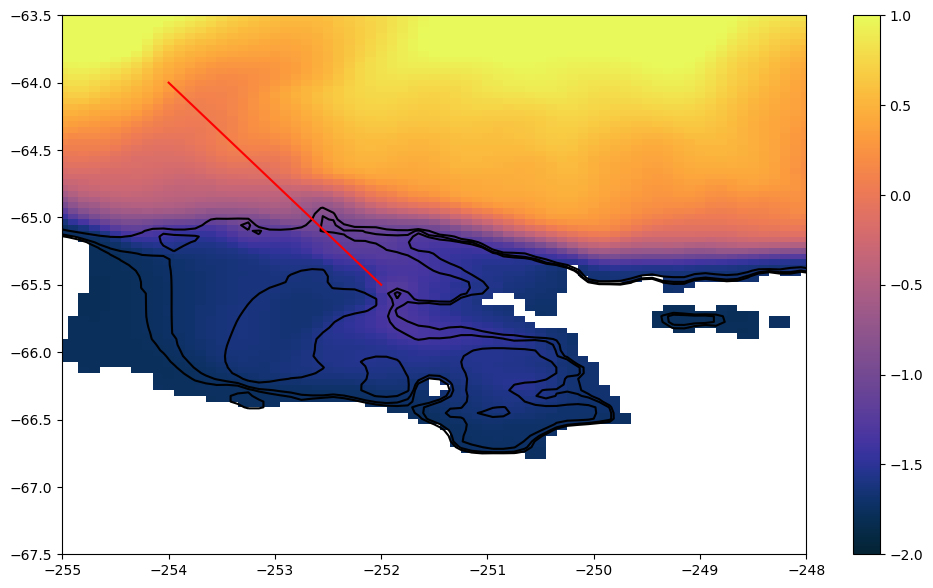

In [9]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -65.5
lat1=-64
lon0 = -252
lon1 = -254

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=1)
plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63.5))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700],colors='k')

save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

Extract nearest points along transect:

In [17]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean

# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# Extract u/v along transect:
u_speed_trans = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')
v_speed_trans = v_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [18]:
# load data before plotting:
sigma0 = sigma0.load()
temp_transect = temp_transect.load()
u_speed_trans = u_speed_trans.load()
v_speed_trans = v_speed_trans.load()

In [19]:
temp_mean = temp_transect.mean('time')
sigma0_mean = sigma0.mean('time')
u_speed_mean = u_speed_trans.mean('time')
v_speed_mean = v_speed_trans.mean('time')

fontsize = 13
# temp contours:
#norm = col.Normalize(vmin=-2,vmax=1)
#levels=np.arange(-2,1.01,.01)
#ticks = [-2,-1,0,1]

#speed contours?

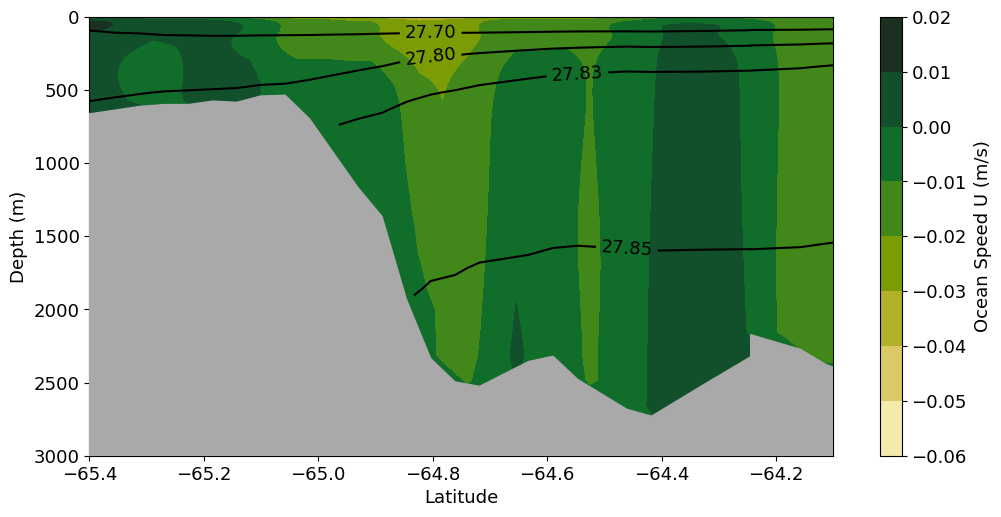

In [29]:
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# set up figure and projection:
fig = plt.figure(1,figsize=(12,5.7))

# plot temperature:
pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
           cmap = cmocean.speed)
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.4,-64.1))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)

# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Speed U (m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_mean.yt_ocean,sigma0_mean.st_ocean,sigma0_mean,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

save_results_to = '/g/data/x77/ns3783/5th_round_analysis/'
plt.savefig(save_results_to + 'ASC_transect_u_speed.png', dpi=120,bbox_inches='tight', pad_inches=0.1)


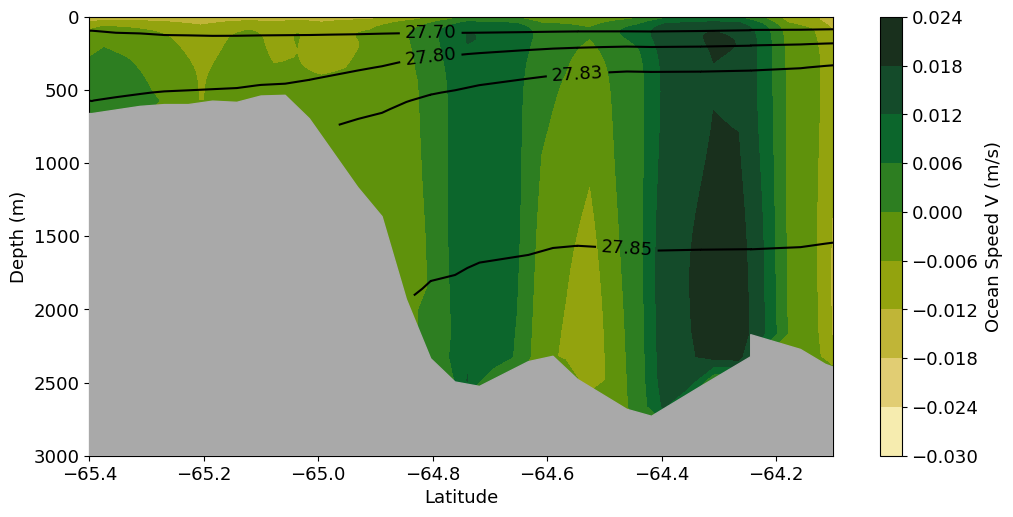

In [30]:
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# set up figure and projection:
fig = plt.figure(1,figsize=(12,5.7))

# plot temperature:
pcm = plt.contourf(v_speed_mean.yu_ocean,v_speed_mean.st_ocean,v_speed_mean.fillna(0),
           cmap = cmocean.speed)
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.4,-64.1))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)

# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Speed V (m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_mean.yt_ocean,sigma0_mean.st_ocean,sigma0_mean,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

save_results_to = '/g/data/x77/ns3783/5th_round_analysis/'
plt.savefig(save_results_to + 'ASC_transect_v_speed.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
